<a href="https://colab.research.google.com/github/lpilastri/MVP-Sprint4/blob/main/MVP_Sprint4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import das Bibliotecas do Python
Header do codigo

In [ ]:
# configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import pickle

Importing Dataset and cleaning null cells

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/lpilastri/MVP-Sprint4/main/water_potability.csv')

target = 'Potability'
labels = [0, 1]
features = [i for i in df.columns.values if i not in [target]]

df['ph'].fillna(df['ph'].mean(),axis=0, inplace=True)
df['Sulfate'].fillna(df['Sulfate'].mean(),axis=0, inplace=True)
df['Trihalomethanes'].fillna(df['Trihalomethanes'].mean(),axis=0, inplace=True)

df.head()

#print('Inference:The Datset consists of {} features & {} samples.'.format(df.shape[1], df.shape[0]))

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,7.080795,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,333.775777,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,333.775777,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


Creating and evaluating models

KNN-orig: 0.568 (0.018)
CART-orig: 0.578 (0.026)
NB-orig: 0.628 (0.018)
SVM-orig: 0.616 (0.001)
KNN-padr: 0.641 (0.020)
CART-padr: 0.577 (0.033)
NB-padr: 0.626 (0.017)
SVM-padr: 0.683 (0.015)
KNN-norm: 0.641 (0.019)
CART-norm: 0.585 (0.015)
NB-norm: 0.626 (0.017)
SVM-norm: 0.677 (0.012)


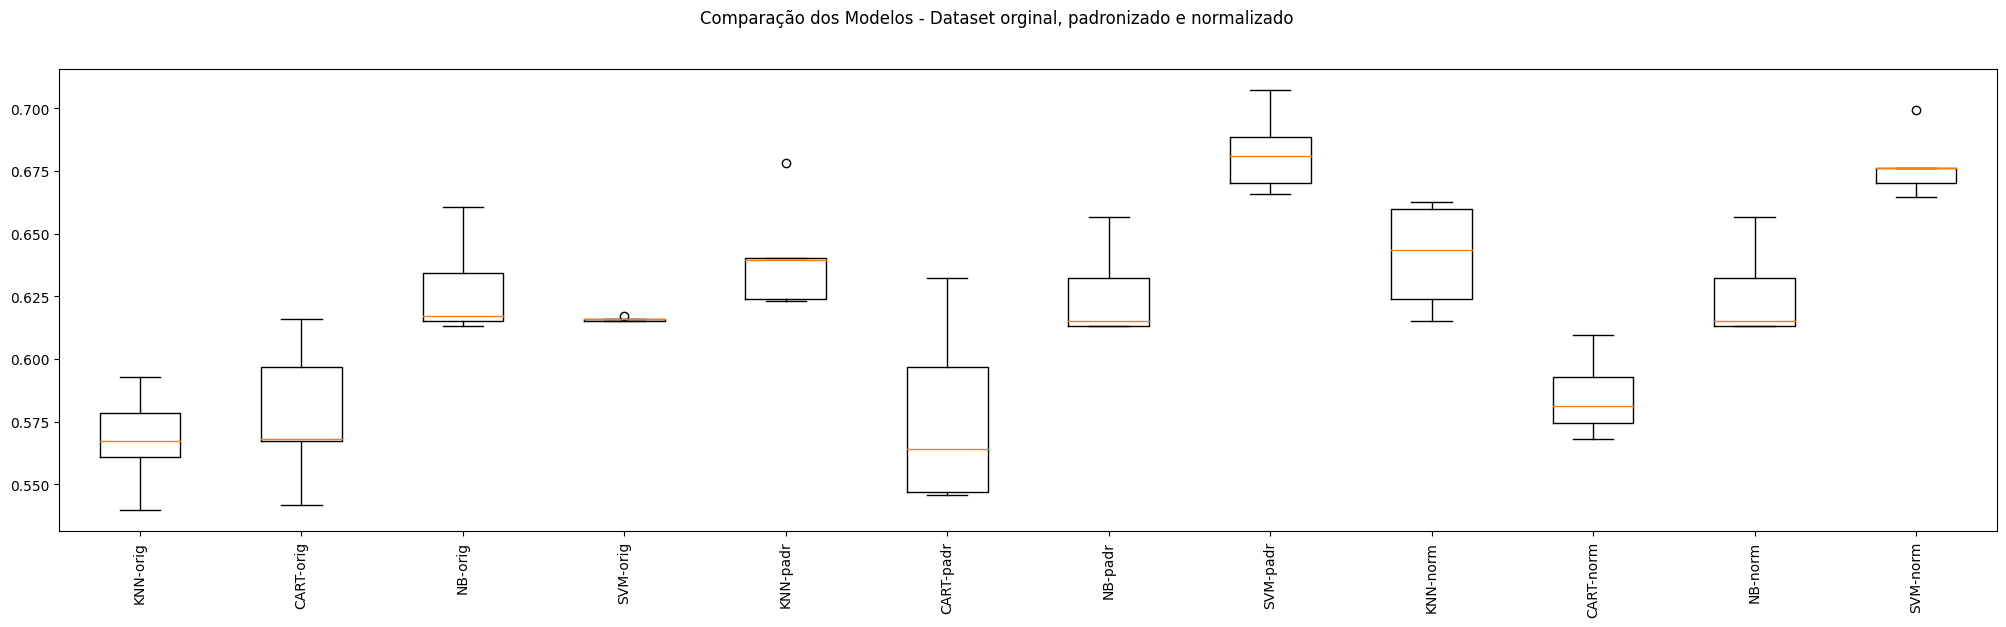

In [ ]:
seed = 7 # definindo uma semente global para este bloco
# Listas para armazenar os armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []

#  Parametros
percentual_teste = 0.25
# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 5
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # validação cruzada com estratificação

# Pré-processamento dataset
#features = []
#for feature in ['ph', 'Solids', 'Organic_carbon', 'Conductivity','Turbidity', 'Potability']: # include target variable in the lats column
#    features.append(feature)

#dataset_feature = df[features]
datas = df.values
X = datas[:, 0:-1]
Y = datas[:, -1]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=percentual_teste, shuffle=True, random_state=seed)

# Criando os elementos do pipeline

# Algoritmos que serão utilizados
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC())

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

# Montando os pipelines

# Dataset original
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('SVM-orig', Pipeline([svm])))

# Dataset Padronizado
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))

# Dataset Normalizado
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))

# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, Y_train, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) # formatando para 3 casas decimais
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

SVM Padrao apresenta melhor desempenho, Otimização de Hiperparametros

In [ ]:
seed = 7 # definindo uma semente global para este bloco

pipelines = []

# Definindo os componentes do pipeline
svm = ('SVM', SVC())
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

pipelines.append(('svm-orig', Pipeline(steps=[svm])))
pipelines.append(('svm-padr', Pipeline(steps=[standard_scaler, svm])))
pipelines.append(('svm-norm', Pipeline(steps=[min_max_scaler, svm])))

# defining parameter range
param_grid = {'SVM__C': [0.1,1, 10, 100], 'SVM__gamma': [1,0.1,0.01,0.001],'SVM__kernel': ['linear','rbf']}

# Prepara e executa o GridSearchCV
for name, model in pipelines:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring)
    grid.fit(X_train, Y_train)
    print("Sem tratamento de missings: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))

Finalizando modelo e testando com conjunto de teste

In [ ]:
# Preparação do modelo
scaler = StandardScaler().fit(X_train) # ajuste do scaler com o conjunto de treino
rescaledX = scaler.transform(X_train) # aplicação da padronização no conjunto de treino
model = SVC(C= 10, kernel='rbf', gamma= 0.1)
model.fit(rescaledX, Y_train)

# Estimativa da acurácia no conjunto de teste
rescaledTestX = scaler.transform(X_test) # aplicação da padronização no conjunto de teste
predictions = model.predict(rescaledTestX)
print(accuracy_score(Y_test, predictions))

0.6410256410256411


Exporting model

In [ ]:
filename = 'model_Water.pkl'
pickle.dump(model, open(filename, 'wb'))

Exporting scaler

In [ ]:
filename = 'scaler_Water.pkl'
pickle.dump(scaler, open(filename, 'wb'))